1. Selection
The Selection phase in KDD is about deciding which data sources are relevant to your project goal.
For this project our goal is to detect whether a news is fake or not.

We are given two datasets: Fake.csv and True.csv
We load these datasets and look for some initial understanding.

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

In [2]:
# 1. Load the data
df_fake = pd.read_csv('./datasets/Fake.csv')
df_true = pd.read_csv('./datasets/True.csv')

2. Preprocessing
The goal of Pre-processing is to clean the raw, selected data to make it suitable for the next stages. Real-world data is often messy, containing missing values, inconsistent formats, and irrelevant information. We must fix this before the model can learn effectively.

This is classification problem, and the model needs a label to do supervised learning on it. So we add anothe column to let us know what kind of data it is. A label of '1' indicates that it is a fake news and '0' otherwise.
We then combine the two datasets into one.

In [3]:
df_fake['label'] = 1
df_true['label'] = 0

df_combined = pd.concat([df_fake, df_true], ignore_index=True)

In [4]:
df_combined.shape

(44898, 5)

In [5]:
print("--- Combined Data Head (First 5 Rows) ---")
print(df_combined.head())

--- Combined Data Head (First 5 Rows) ---
                                               title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date  label  
0  December 31, 2017      1  
1  December 31, 2017      1  
2  December 30, 2017      1  
3  December 29, 2017      1  
4  December 25, 2017      1  


In [6]:
print("\n--- Combined Data Information ---")
print(df_combined.info())


--- Combined Data Information ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.7+ MB
None


We check if the dataset has some missing values in it.
Our dataset is clean and has no missingness. Hence, we need not impute it.

In [7]:
df_combined.isnull().sum()

title      0
text       0
subject    0
date       0
label      0
dtype: int64

Check if the dataset has some duplicates. Have duplicates can make the model more bias to the same set of data and also increase computational cost.
Smaller the dataset, better is the prediction. There are about 209 duplicate data in our dataset. We simply remove these duplicate data and proceed to the next step.

In [8]:
df_combined.duplicated().sum()

np.int64(209)

In [9]:
df_combined.drop_duplicates(inplace=True)

In [10]:
df_combined.shape

(44689, 5)

In [11]:
print(df_combined['label'].value_counts())
print(f"Imbalance ratio (Fake:True) = {df_combined['label'].value_counts()[1] / df_combined['label'].value_counts()[0]:.3f} : 1")

label
1    23478
0    21211
Name: count, dtype: int64
Imbalance ratio (Fake:True) = 1.107 : 1


We determine if the dataset is imbalaned. The ratio of fake to true is 1.107:1 seems fairly balanced, which is a good thing.

3. Transform

In [12]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(
    df_combined['text'],
    df_combined['label'],
    test_size=0.2,
    random_state=42,
    stratify=df_combined['label']
)

In [13]:
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re


def process_text(text):
    """Clean, tokenize, remove stopwords and lemmatize. Returns a single string (document).

    Input: raw text (may be NaN or non-string)
    Output: cleaned string suitable for TF-IDF
    """
    if pd.isna(text):
        return ""
    # Ensure string and lowercase
    text = str(text).lower()
    # Remove non-alpha characters (keep spaces)
    text = re.sub(r'[^a-z\s]', ' ', text)
    # Tokenize
    words = word_tokenize(text)
    # Remove stopwords and very short tokens
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if w not in stop_words and len(w) > 1]
    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(w) for w in words]
    # Return as single string (TF-IDF expects raw documents)
    return ' '.join(words)


In [14]:
# Fill missing values before applying processing and ensure we get strings back
X_trained = X_train.fillna('').apply(process_text)
X_tested = X_test.fillna('').apply(process_text)

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=5000)
vectorizer.fit(X_trained)

X_train_vectorized = vectorizer.transform(X_trained)
X_test_vectorized = vectorizer.transform(X_tested)

4. Data Mining

The goal of Data Mining (or Model Training) is to apply intelligent algorithms to the transformed data to extract patterns. The outcome is a predictive model. 

We choose a simple logistic reggressor method to train the model.

In [16]:
from sklearn.linear_model import LogisticRegression


model = LogisticRegression()
model.fit(X_train_vectorized, y_train)
y_pred = model.predict(X_test_vectorized)

The model is trained and has made predictions on the test set. We are now ready for the final step, Evaluation.

5. Evaluation

The goal of Evaluation is to measure the model's performance on the unseen test data. Interpretation is about understanding why the model made its decisions, which is crucial for turning "data" into "knowledge."

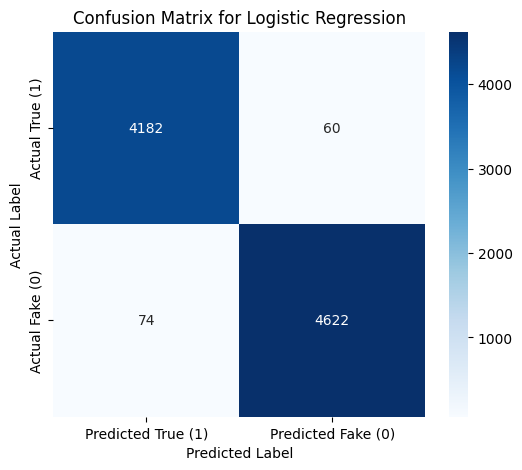

Classification Report 
               precision    recall  f1-score   support

           0       0.98      0.99      0.98      4242
           1       0.99      0.98      0.99      4696

    accuracy                           0.99      8938
   macro avg       0.98      0.99      0.98      8938
weighted avg       0.99      0.99      0.99      8938
 

Accuracy score: 0.9850


In [17]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted True (1)', 'Predicted Fake (0)'],
            yticklabels=['Actual True (1)', 'Actual Fake (0)'])
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

print(f"Classification Report \n{'=' * 20} \n {classification_report(y_test, y_pred)} \n")
print(f"Accuracy score: {accuracy_score(y_test, y_pred):.4f}")

With the above data, we can interpret that our model has performed  consistently accurate with about 98.5% accuracy score. It correctly identified 4,622 positives and 4,182 negatives, with only 134 mistakes (60 FP, 74 FN). With precision and recall ~0.98–0.99 for both the classes, indicates that the prediction is balanced  and not favoring one class over the other. 